# Formula learning - regression

Idea is to learn a function : $f(\mathbf{x}) = \frac{x_1 - x_n}{x_1 + x_n}$ with $\mathbf{x}=(x_1, x_2, ...,x_n)$

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib notebook

## Prepare input data

Let's take $n=5$ and $x_i$ to be normalized between 0 and 1. Input $\mathbf{x}$ is a random noise between 0 and 1. Targets are computed by the formula $f(\mathbf{x}) = \frac{x_1 - x_n}{x_1 + x_n}$.

In [4]:
n_samples = 5000
ndim = 5
inputs = np.random.rand(n_samples, ndim)
targets = (inputs[:, 0] - inputs[:, ndim-1])/(inputs[:, 0] + inputs[:, ndim-1] + 0)

<IPython.core.display.Javascript object>


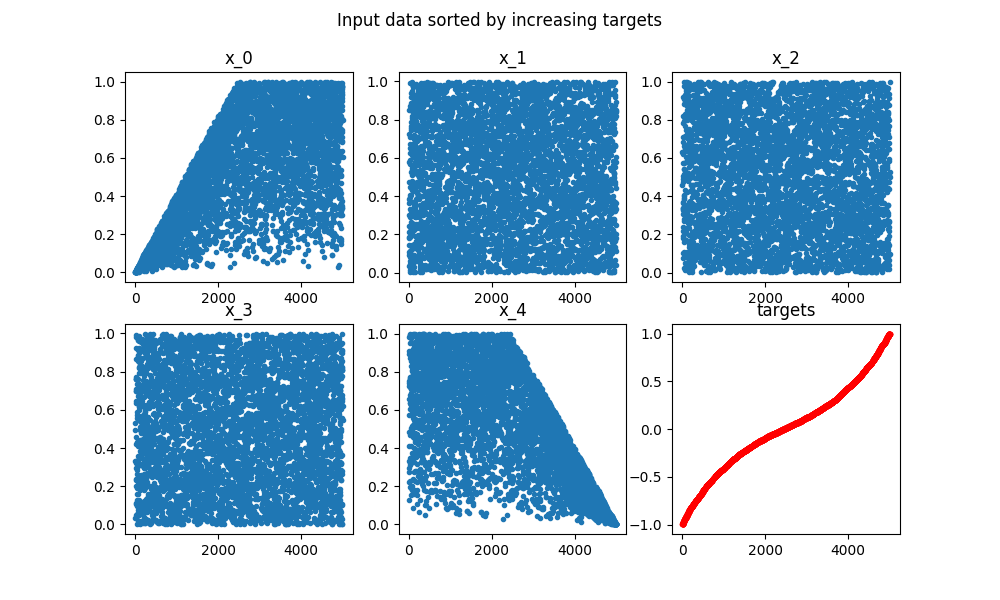

In [5]:
args = targets.argsort()

plt.figure(figsize=(10,6))
plt.suptitle("Input data sorted by increasing targets")
plt.subplot(231)
plt.plot(inputs[args,0], '.')
plt.title("x_0")
plt.subplot(232)
plt.plot(inputs[args,1], '.')
plt.title("x_1")
plt.subplot(233)
plt.plot(inputs[args,2], '.')
plt.title("x_2")
plt.subplot(234)
plt.plot(inputs[args,3], '.')
plt.title("x_3")
plt.subplot(235)
plt.plot(inputs[args,4], '.')
plt.title("x_4")
plt.subplot(236)
plt.plot(targets[args], '.r')
plt.title("targets")

## Fully-connected NN

Let's try a simple network architecture with 3 hidden fully-connected layers to approximate the target function.

In [12]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input

In [7]:
x_in = Input((ndim,))
x = Dense(100, activation='relu', init='normal')(x_in)
x = Dense(100, activation='relu', init='normal')(x)
x = Dense(50, activation='tanh', init='normal')(x)
x_out = Dense(1)(x)
model = Model(input=x_in, output=x_out)

In [8]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 5)             0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 100)           600         input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 100)           10100       dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 50)            5050        dense_2[0][0]                    
___________________________________________________________________________________________

In [9]:
from keras import backend as K

def K_max_error_percentage(y_true, y_pred):
    return K.max(K.abs(y_true - y_pred)) * 100.0


def max_error_percentage(y_true, y_pred):
    return np.max(np.abs(y_true - y_pred)) * 100.0

In [10]:
model.compile(loss='mae', optimizer='adam', metrics=['mae', K_max_error_percentage])

In [11]:
batch_size = 64
history = model.fit(inputs, targets, shuffle=True, batch_size=batch_size, validation_split=0.3, nb_epoch=1000, verbose=0)

<IPython.core.display.Javascript object>


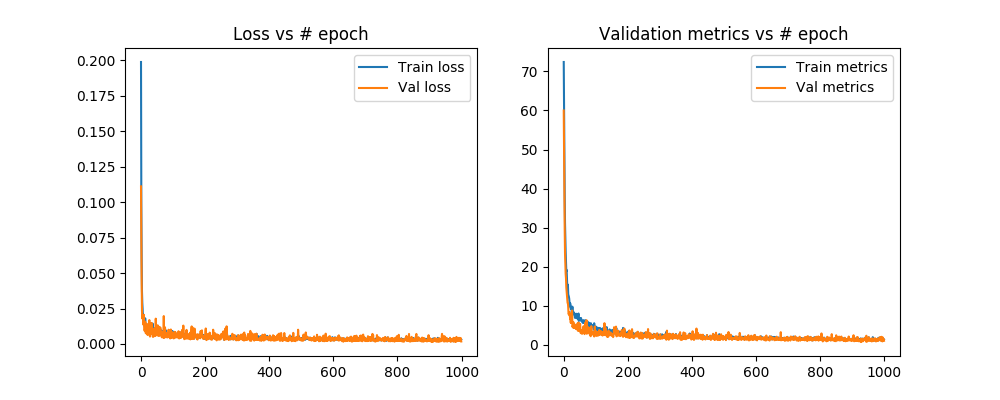

In [13]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Loss vs # epoch")
plt.legend()
plt.subplot(122)
plt.plot(history.history['K_max_error_percentage'], label='Train metrics')
plt.plot(history.history['val_K_max_error_percentage'], label='Val metrics')
plt.title("Validation metrics vs # epoch")
plt.legend()

In [14]:
X_test = np.random.rand(100, ndim)
Y_test = (X_test[:, 0] - X_test[:, ndim-1])/(X_test[:, 0] + X_test[:, ndim-1])

In [15]:
Y_pred = model.predict(X_test)

In [16]:
args = Y_test.argsort()
y_true = Y_test[args]
y_pred = Y_pred.ravel()[args]

In [17]:
from sklearn.metrics import mean_absolute_error

In [18]:
mean_absolute_error(Y_test, Y_pred), max_error_percentage(y_true, y_pred)

(0.0015021594472094412, 0.69592117521963814)

<IPython.core.display.Javascript object>


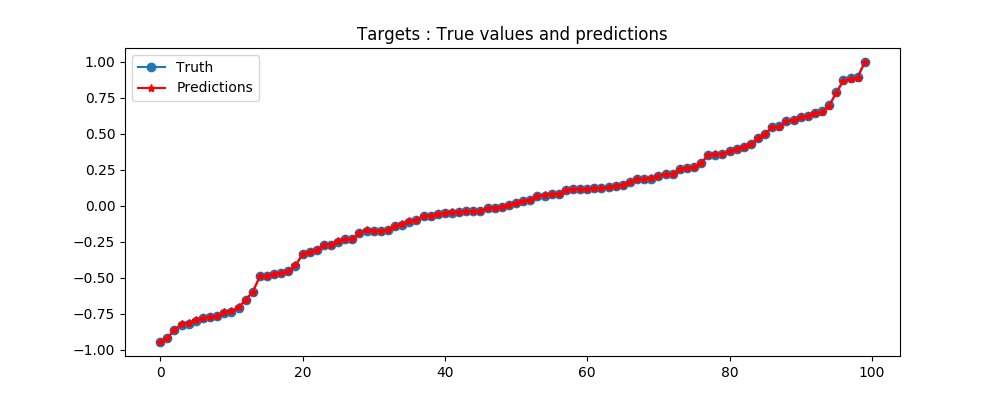

In [20]:
plt.figure(figsize=(10, 4))
plt.plot(y_true, 'o-', label='Truth')
plt.title("Targets : True values and predictions")
plt.plot(y_pred, '*-r', label='Predictions')
_ = plt.legend()

After a lot of epoch of training, we manage to predict the function with a small mean absolute error.

### Show weights of the trained network

We can observe that :
- variations of weights for the first and the last channels of the first Dense layer

<IPython.core.display.Javascript object>


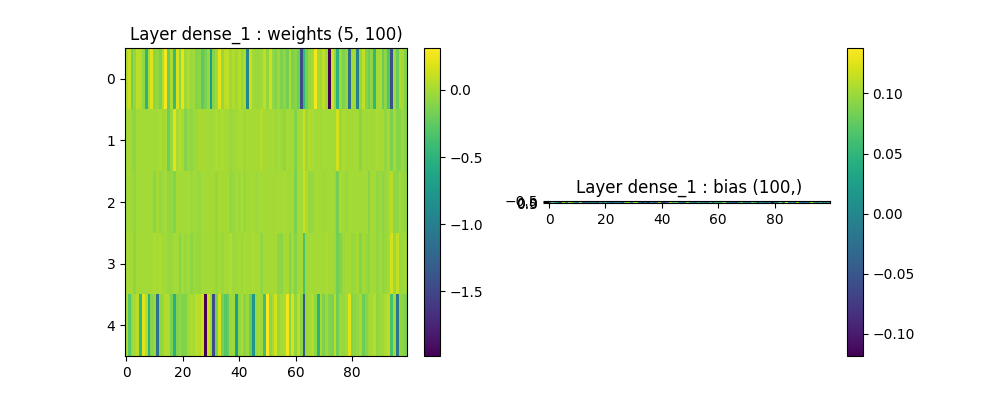

<IPython.core.display.Javascript object>


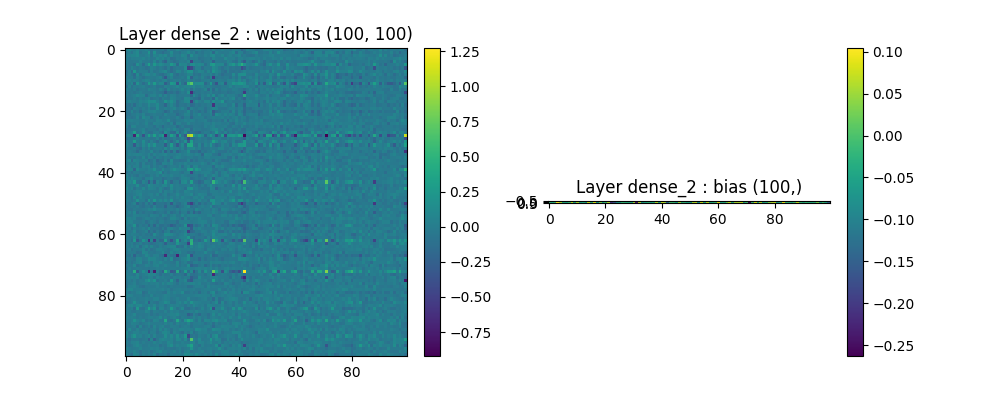

<IPython.core.display.Javascript object>


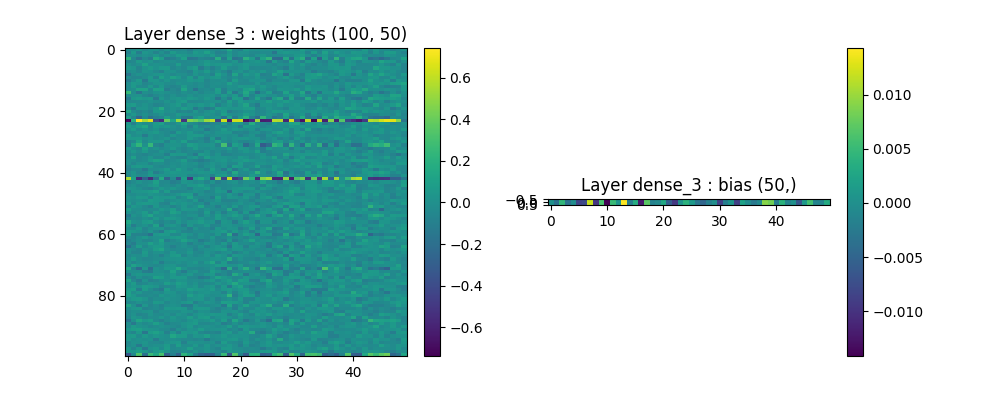

<IPython.core.display.Javascript object>


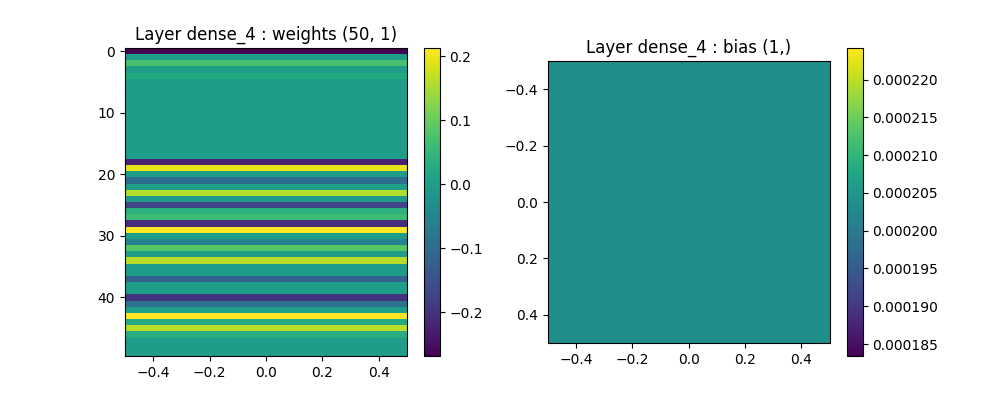

In [21]:
layers = list(model.layers)
layers.remove(model.input_layers[0])
for layer in layers:
    weights = layer.W.eval()
    b = layer.b.eval()
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.title("Layer {} : weights {}".format(layer.name, weights.shape))
    plt.imshow(weights, interpolation='none', aspect='auto')    
    plt.colorbar()
    plt.subplot(122)
    plt.title("Layer {} : bias {}".format(layer.name, b.shape))    
    b = np.expand_dims(b, axis=0)    
    plt.imshow(b, interpolation='none')    
    plt.colorbar()
    

Display the transformation on a data by each layer

In [22]:
import keras.backend as K

def get_layer_output_func(layer_name, model):
    inputs = [K.learning_phase()] + model.inputs
    output_layer = model.get_layer(name=layer_name)
    outputs = output_layer.output
    return K.function(inputs, [outputs])
    
    
def compute_layer_output(input_data, layer_output_f):
    return layer_output_f([0] + [input_data])


def compute_layer_outputs(input_data, model, layer_output_f_dict={}, layer_names=None):
    """
    Method to compute (all or only those specified by `layer_names`) layer outputs on `input_data` for a given `model`
    :return: tuple of pairs: [("layer_name_1", ndarray), ...]
    """
    if layer_names is None:
        inputs_outputs = model.input_layers
        inputs_outputs.extend(model.output_layers)
        layer_names = [layer.name for layer in model.layers if layer not in inputs_outputs]        
    else:
        all_layer_names = [layer.name for layer in model.layers]
        assert set(layer_names) & set(all_layer_names) == set(layer_names), \
            "Items {} of layer_names are not in model".format(set(layer_names) - set(layer_names))

    layer_outputs = []
    for layer_name in layer_names:
        print("-- %s" % layer_name)
        if layer_name not in layer_output_f_dict:
            layer_output_f_dict[layer_name] = get_layer_output_func(layer_name, model)
        layer_outputs.append((layer_name, compute_layer_output(input_data, layer_output_f_dict[layer_name])))
    return layer_outputs

In [23]:
x = np.array([
    [0.1, 0.2, 0.0, 0.1, 0.3],
    [0.2, 0.3, 0.2, 0.4, 0.4],
    [0.4, 0.8, 0.3, 0.5, 0.1],
    [0.7, 0.8, 0.2, 0.1, 0.7],
    [0.7, 0.8, 0.8, 0.6, 0.0],    
])

# Targets should be 
#   (0.1 - 0.3) / (0.1 + 0.3) = -0.2 / 0.4 = -0.5
#   (0.2 - 0.4) / (0.2 + 0.4) = -0.2 / 0.6  = -0.3333
#   (0.4 - 0.1) / (0.4 + 0.1) = 0.3 / 0.5 = 0.6
#   (0.7 - 0.7) / (0.7 + 0.7) = 0.0 / 1.4 = 0.0
#   (0.7 - 0.0) / (0.7 + 0.0) = 0.7 / 0.7 = 1.0

layer_output_f_dict = {}
layer_outputs = compute_layer_outputs(x[:1,:], model, layer_output_f_dict)

for layer_name, layer_output in layer_outputs:
    print "\n", layer_name
    print layer_output[0], layer_output[0].shape

print "\n Predictions :"
print model.predict(x)

-- dense_1
-- dense_2
-- dense_3

dense_1
[[ 0.          0.00184145  0.          0.          0.          0.
   0.07020799  0.0619524   0.          0.02307341  0.          0.          0.
   0.          0.0204322   0.          0.          0.          0.0358981
   0.          0.01504351  0.          0.          0.          0.
   0.01577306  0.          0.10397422  0.          0.04399103  0.04028673
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.01386575
   0.0169311   0.          0.          0.          0.          0.
   0.10236869  0.          0.          0.09058291  0.          0.          0.
   0.13317105  0.          0.08791974  0.          0.0654196   0.          0.
   0.          0.          0.          0.02338353  0.          0.          0.
   0.          0.          0.02256082  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.

This architecture make target function's $f(\mathbf{x}) = \frac{x_0 - x_{n-1}}{x_0 + x_{n-1}}$ approximation by the following expression:

$$
NN(\mathbf{x}) = b_4 + \langle \mathbf{W}_4, \text{relu}( \mathbf{b}_3 + \langle \mathbf{W}_3, \text{relu}( \mathbf{b}_2 + \langle \mathbf{W}_2, \text{relu}( \mathbf{b}_1 + \langle \mathbf{W}_1, \mathbf{x} \rangle ) \, \rangle ) \, \rangle )
$$

15,801 of weights trained to make an approximation of the function


Plot theoretical and approximative functions

In [24]:
nb_samples = 200
x = np.zeros((nb_samples**2, ndim), dtype=np.float32)

t = np.linspace(0.0, 5.0, num=nb_samples)
for i in range(nb_samples):
    x[i*nb_samples:(i+1)*nb_samples, 0] = np.linspace(0.0, 5.0, num=nb_samples)
    x[i*nb_samples:(i+1)*nb_samples, -1] = t[i]

f = model.predict(x).ravel()

In [25]:
X, Y = np.meshgrid(x[:nb_samples, 0], x[::nb_samples, -1])
f = f.reshape((nb_samples, nb_samples))

In [26]:
f2 = (X - Y) / (X + Y + 0.0001)

<IPython.core.display.Javascript object>


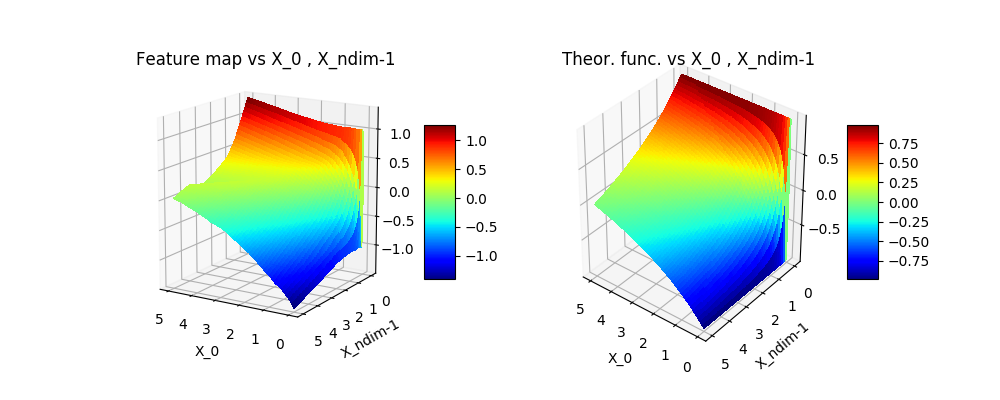

In [27]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(10, 4))
ax = plt.subplot(1,2,1,projection='3d')
surf = ax.plot_surface(X, Y, f, cmap='jet', linewidth=0, antialiased=False)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Feature map vs X_0 , X_ndim-1")
plt.xlabel("X_0")
plt.ylabel("X_ndim-1")
ax = plt.subplot(1,2,2,projection='3d')
surf = ax.plot_surface(X, Y, f2, cmap='jet', linewidth=0, antialiased=False)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Theor. func. vs X_0 , X_ndim-1")
plt.xlabel("X_0")
plt.ylabel("X_ndim-1")

<IPython.core.display.Javascript object>


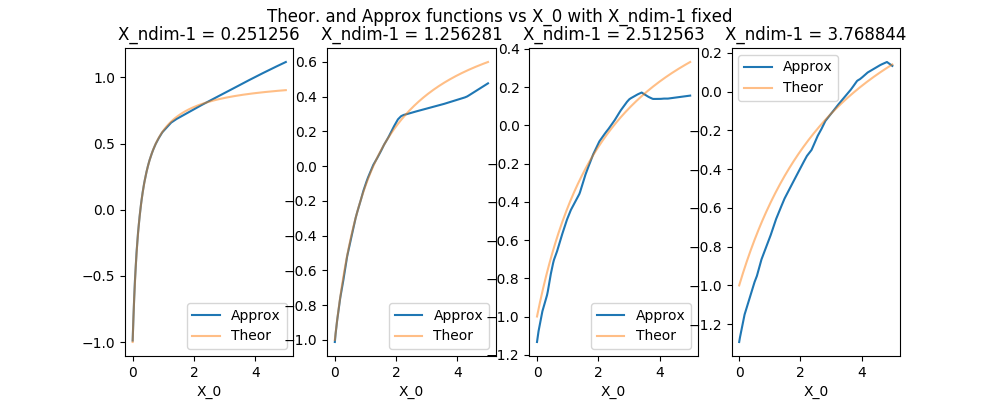

In [29]:
plt.figure(figsize=(10, 4))
t = np.linspace(0.0, 5.0, num=nb_samples)
plt.suptitle("Theor. and Approx functions vs X_0 with X_ndim-1 fixed")
for i, index in enumerate([int(nb_samples * 0.05), int(nb_samples * 0.25), int(nb_samples * 0.5), int(nb_samples * 0.75)]):
    plt.subplot(1, 4, i+1)
    plt.title("X_ndim-1 = %f" % t[index])
    plt.plot(x[:nb_samples, 0], f[index, :], label='Approx')
    plt.plot(x[:nb_samples, 0], f2[index, :], alpha=0.5, label='Theor')    
    plt.xlabel('X_0')
    plt.legend()


<IPython.core.display.Javascript object>


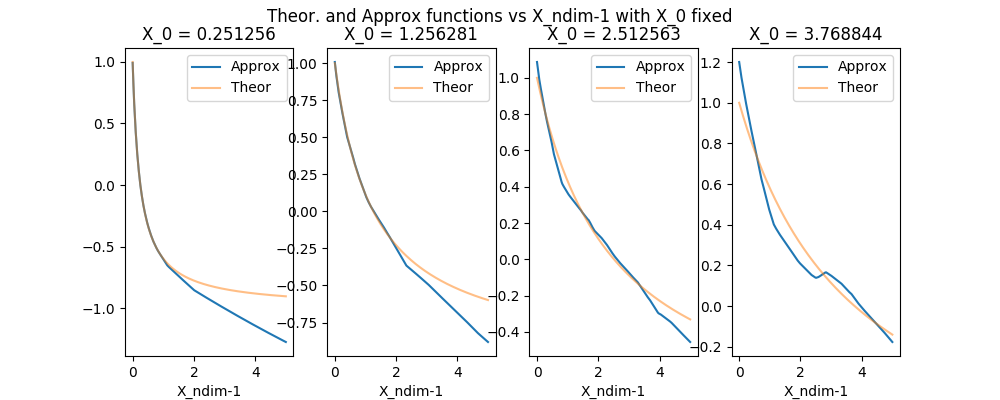

In [30]:
plt.figure(figsize=(10, 4))
t = np.linspace(0.0, 5.0, num=nb_samples)
plt.suptitle("Theor. and Approx functions vs X_ndim-1 with X_0 fixed")
for i, index in enumerate([int(nb_samples * 0.05), int(nb_samples * 0.25), int(nb_samples * 0.5), int(nb_samples * 0.75)]):
    plt.subplot(1, 4, i+1)
    plt.title("X_0 = %f" % t[index])
    plt.plot(x[::nb_samples, -1], f[:, index], label='Approx')
    plt.plot(x[::nb_samples, -1], f2[:, index], alpha=0.5, label='Theor')    
    plt.xlabel('X_ndim-1')
    plt.legend()


## Fraction architecture

Let $\mathbf{x}$ be an input, then a $i$-th feature map defines as $\mathbf{f}_i = \text{relu}(\mathbf{b}_i + \langle \mathbf{W}_i,\mathbf{x} \rangle)$.

We would like to obtain something similar to
$$
f_{fraction} = \frac{\sum_{\mathbf{\alpha}} \langle \mathbf{\alpha},  \mathbf{x} \rangle }{\sum_{\mathbf{\beta}} \langle \mathbf{\beta}, \mathbf{x} \rangle }
$$

Numerator and denominator parts can be achieved with two fully-connected layers: `input -> Dense(N) -> Dense(1) -> output`. It gives the following expression:
$$
f = b_{2} + \langle \mathbf{W}_2, \text{activation}(\mathbf{b}_1 + \langle \mathbf{W}_1, \mathbf{x}\rangle) \rangle
$$


Best performance is achieved with linear activation, hidden fully-connected layer can be rather small (`N=2`). We have 30 parameters to learn.



In [31]:
from keras.layers import merge

In [32]:
max_power = 1

x_in = Input((ndim,))

def create_powers(input_layer, max_power, nb_layers=1, n_filters=100):
    # Create `max_power` of combinations [c + w*x_in]
    xs = []
    x = input_layer
    for i in range(max_power):
        for i in range(nb_layers):
            x = Dense(n_filters, init='one')(x)        
        xs.append(x)

    # Merge multiply:
    if len(xs) > 1:
        x = merge([xs[0], xs[1]], mode='mul')
        for i in range(max_power - 2):
            x = merge([x, xs[i+2]], mode='mul')
    else:
        x = xs[0]
    return x

# Create numerator & denominator
x_numerator = create_powers(x_in, max_power, nb_layers=1, n_filters=2)
x_numerator = Dense(1, init='one', name='numerator')(x_numerator)
x_denominator = create_powers(x_in, max_power, nb_layers=1, n_filters=2)
x_denominator = Dense(1, init='one', name='denominator')(x_denominator)
    
# Divide
def division(list_of_tensors): 
    return list_of_tensors[0] / (list_of_tensors[1] + K.epsilon())

x = merge([x_numerator, x_denominator], mode=division, output_shape=x_numerator._keras_shape[1:], name='fraction')
x_out = x

model = Model(input=x_in, output=x_out)

In [33]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 5)             0                                            
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 2)             12          input_2[0][0]                    
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 2)             12          input_2[0][0]                    
____________________________________________________________________________________________________
numerator (Dense)                (None, 1)             3           dense_5[0][0]                    
___________________________________________________________________________________________

In [34]:
from keras.metrics import mean_absolute_error, mean_squared_error

def K_mix_loss(y_true, y_pred):
    return 100.0 * (K.square(mean_absolute_error(y_true, y_pred)) + mean_squared_error(y_true, y_pred))

In [35]:
model.compile(loss=K_mix_loss, optimizer='nadam', metrics=[K_max_error_percentage])

In [36]:
batch_size = 64
history = model.fit(inputs, targets, shuffle=True, batch_size=batch_size, validation_split=0.3, nb_epoch=1000, verbose=0)

<IPython.core.display.Javascript object>


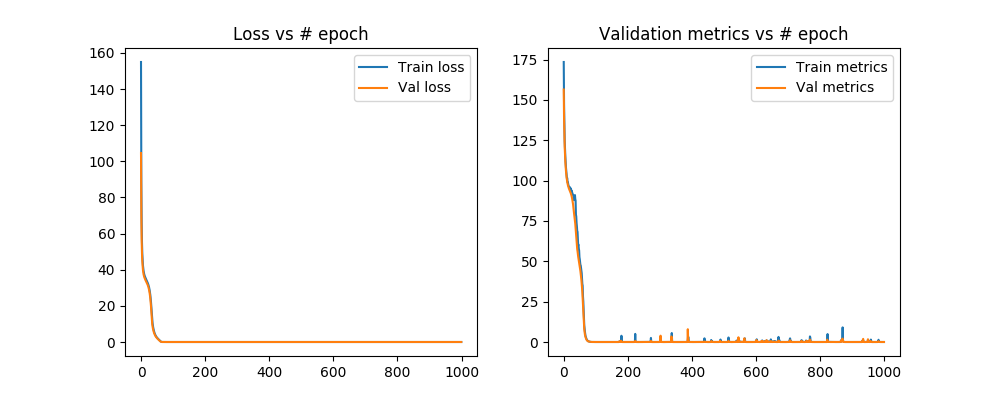

In [37]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Loss vs # epoch")
plt.legend()
plt.subplot(122)
plt.plot(history.history['K_max_error_percentage'], label='Train metrics')
plt.plot(history.history['val_K_max_error_percentage'], label='Val metrics')
plt.title("Validation metrics vs # epoch")
plt.legend()

In [38]:
X_test = np.random.rand(100, ndim)
Y_test = (X_test[:, 0] - X_test[:, ndim-1])/(X_test[:, 0] + X_test[:, ndim-1])

In [39]:
Y_pred = model.predict(X_test)

In [40]:
args = Y_test.argsort()
y_true = Y_test[args]
y_pred = Y_pred.ravel()[args]

In [41]:
from sklearn.metrics import mean_absolute_error

In [42]:
print mean_absolute_error(y_true, y_pred), max_error_percentage(y_true, y_pred)

3.35618980502e-07 0.000686844610431


<IPython.core.display.Javascript object>


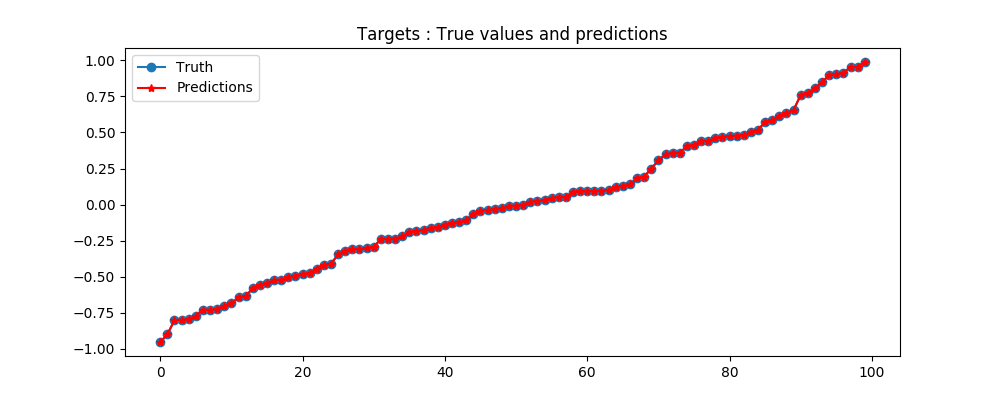

In [44]:
plt.figure(figsize=(10, 4))
plt.plot(y_true, 'o-', label='Truth')
plt.title("Targets : True values and predictions")
plt.plot(y_pred, '*-r', label='Predictions')
_ = plt.legend()

In [45]:
x = np.array([
    [0.1, 0.2, 0.0, 0.1, 0.3],
    [0.2, 0.3, 0.2, 0.4, 0.4],
    [0.4, 0.8, 0.3, 0.5, 0.1],
    [0.7, 0.8, 0.2, 0.1, 0.7],
    [0.7, 0.8, 0.8, 0.6, 0.0],    
])

# Targets should be 
#   (0.1 - 0.3) / (0.1 + 0.3) = -0.2 / 0.4 = -0.5
#   (0.2 - 0.4) / (0.2 + 0.4) = -0.2 / 0.6  = -0.3333
#   (0.4 - 0.1) / (0.4 + 0.1) = 0.3 / 0.5 = 0.6
#   (0.7 - 0.7) / (0.7 + 0.7) = 0.0 / 1.4 = 0.0
#   (0.7 - 0.0) / (0.7 + 0.0) = 0.7 / 0.7 = 1.0

layer_output_f_dict = {}
layer_outputs = compute_layer_outputs(x, model, layer_output_f_dict, layer_names=['numerator', 'denominator'])

for layer_name, layer_output in layer_outputs:
    print "\n", layer_name
    print layer_output[0]

print "\n Predictions :"
print model.predict(x)

-- numerator
-- denominator

numerator
[[ -6.74399972e-01]
 [ -6.74399614e-01]
 [  1.01159835e+00]
 [ -8.19563866e-07]
 [  2.36039758e+00]]

denominator
[[ 1.34879839]
 [ 2.02319837]
 [ 1.68599927]
 [ 4.72079659]
 [ 2.36039925]]

 Predictions :
[[ -5.00000536e-01]
 [ -3.33333403e-01]
 [  5.99999249e-01]
 [ -1.73607120e-07]
 [  9.99999285e-01]]


Let's compute the derivatives on $\mathbf{x}$ (Jacobian and Hessian matricies) of the output to observe a non-linearity of the output of the feature map. Implementation continues using `theano`

Derivatives of the feature map function $f(\mathbf{x}) = \frac{x_0 - x_{n-1}}{x_0 + x_{n-1}}$ is 

$$\frac{\partial f}{\partial x_i} = \frac{2 x_{n-1} } {(x_0 + x_{n-1})^2} \delta_{i\,0} - \frac{2 x_{0} } {(x_0 + x_{n-1})^2} \delta_{i\, n-1}$$

If function approximation by NN is a ratio function then 
$$\frac{\partial f}{\partial x_0} \sim \frac{1}{x_0^2} \text{ and } \frac{\partial f}{\partial x_{n-1}} \sim -\frac{1}{x_{n-1}^2} $$


In [46]:
import theano
from theano import tensor as T

In [47]:
x_in = model.inputs[0]
feature_map = T.flatten(model.outputs[0])

In [48]:
Jacobian = T.jacobian(feature_map, x_in)
jacobian = theano.function([x_in], Jacobian)

<IPython.core.display.Javascript object>


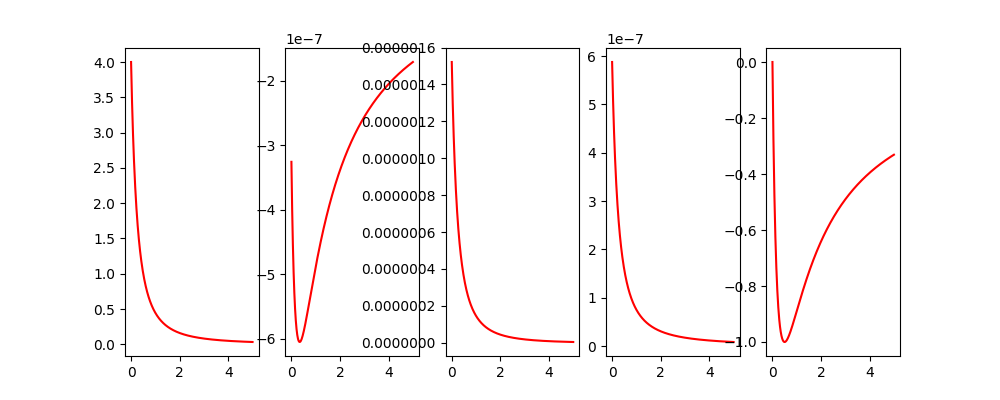

In [49]:
x0 = np.arange(0.0, 5.0, 0.01, dtype=np.float32)
x = np.zeros((len(x0), ndim), dtype=np.float32)
x[:, 0] = x0
x[:, -1] = 0.5
dfdx = np.array([jacobian(x[i:i+1,:])[0, 0] for i in range(x.shape[0])])

plt.figure(figsize=(10, 4))
for i in range(ndim):
    plt.subplot(1, ndim, i+1)
    plt.plot(x0, dfdx[:, i], '-r')

<IPython.core.display.Javascript object>


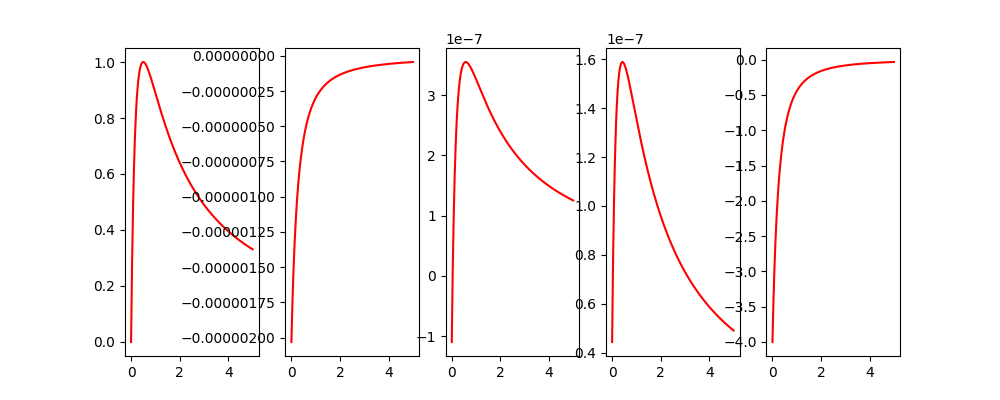

In [50]:
x0 = np.arange(0.0, 5.0, 0.01, dtype=np.float32)
x = np.zeros((len(x0), ndim), dtype=np.float32)
x[:, -1] = x0
x[:, 0] = 0.5
dfdx = np.array([jacobian(x[i:i+1,:])[0, 0] for i in range(x.shape[0])])

plt.figure(figsize=(10, 4))
for i in range(ndim):
    plt.subplot(1, ndim, i+1)
    plt.plot(x0, dfdx[:, i], '-r')

Plot theoretical and approximative functions

In [51]:
nb_samples = 200
x = np.zeros((nb_samples**2, ndim), dtype=np.float32)

t = np.linspace(0.0, 5.0, num=nb_samples)
for i in range(nb_samples):
    x[i*nb_samples:(i+1)*nb_samples, 0] = np.linspace(0.0, 5.0, num=nb_samples)
    x[i*nb_samples:(i+1)*nb_samples, -1] = t[i]

f = model.predict(x).ravel()

In [52]:
X, Y = np.meshgrid(x[:nb_samples, 0], x[::nb_samples, -1])
f = f.reshape((nb_samples, nb_samples))

In [53]:
f2 = (X - Y) / (X + Y + 0.0001)

<IPython.core.display.Javascript object>


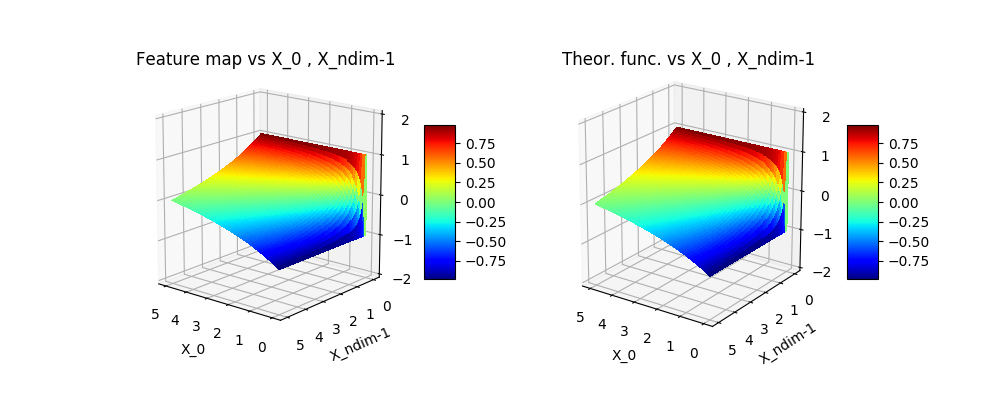

In [54]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(10, 4))
ax = plt.subplot(1,2,1,projection='3d')
surf = ax.plot_surface(X, Y, f, cmap='jet', linewidth=0, antialiased=False)
ax.set_zlim(-2.0, 2.0)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Feature map vs X_0 , X_ndim-1")
plt.xlabel("X_0")
plt.ylabel("X_ndim-1")
ax = plt.subplot(1,2,2,projection='3d')
surf = ax.plot_surface(X, Y, f2, cmap='jet', linewidth=0, antialiased=False)
ax.set_zlim(-2.0, 2.0)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Theor. func. vs X_0 , X_ndim-1")
plt.xlabel("X_0")
plt.ylabel("X_ndim-1")

<IPython.core.display.Javascript object>


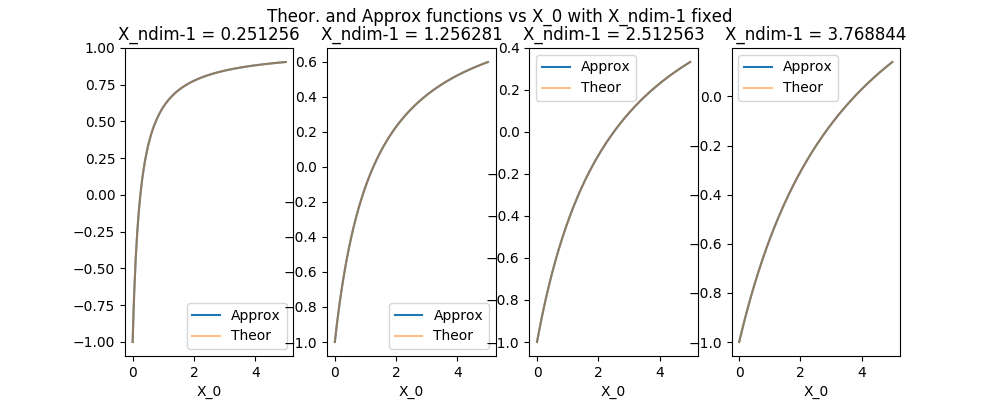

In [55]:
plt.figure(figsize=(10, 4))
t = np.linspace(0.0, 5.0, num=nb_samples)
plt.suptitle("Theor. and Approx functions vs X_0 with X_ndim-1 fixed")
for i, index in enumerate([int(nb_samples * 0.05), int(nb_samples * 0.25), int(nb_samples * 0.5), int(nb_samples * 0.75)]):
    plt.subplot(1, 4, i+1)
    plt.title("X_ndim-1 = %f" % t[index])
    plt.plot(x[:nb_samples, 0], f[index, :], label='Approx')
    plt.plot(x[:nb_samples, 0], f2[index, :], alpha=0.5, label='Theor')    
    plt.xlabel('X_0')
    plt.legend()


<IPython.core.display.Javascript object>


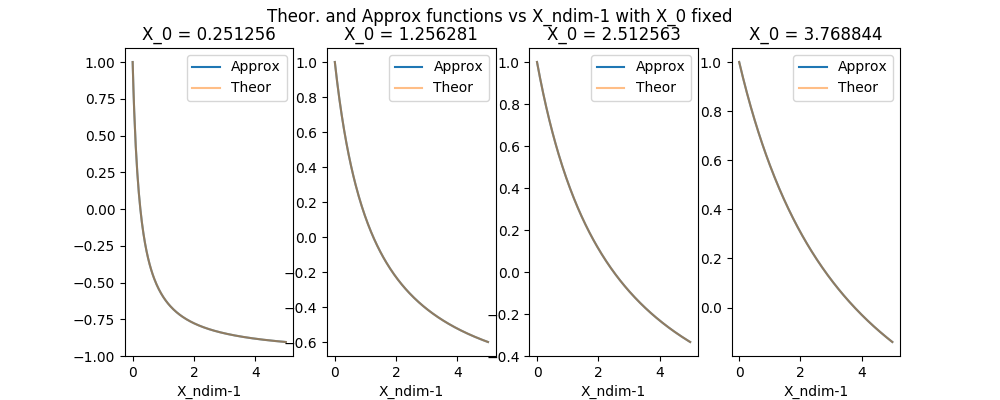

In [56]:
plt.figure(figsize=(10, 4))
t = np.linspace(0.0, 5.0, num=nb_samples)
plt.suptitle("Theor. and Approx functions vs X_ndim-1 with X_0 fixed")
for i, index in enumerate([int(nb_samples * 0.05), int(nb_samples * 0.25), int(nb_samples * 0.5), int(nb_samples * 0.75)]):
    plt.subplot(1, 4, i+1)
    plt.title("X_0 = %f" % t[index])
    plt.plot(x[::nb_samples, -1], f[:, index], label='Approx')
    plt.plot(x[::nb_samples, -1], f2[:, index], alpha=0.5, label='Theor')    
    plt.xlabel('X_ndim-1')
    plt.legend()


### Show weights of the trained network

We can observe that :
- Weights of numerator are distributed as $(w, 0, 0, 0, -w)$
- Weights of denominator are distributed as $(w', 0, 0, 0, w')$
- Other weights are just scales

<IPython.core.display.Javascript object>


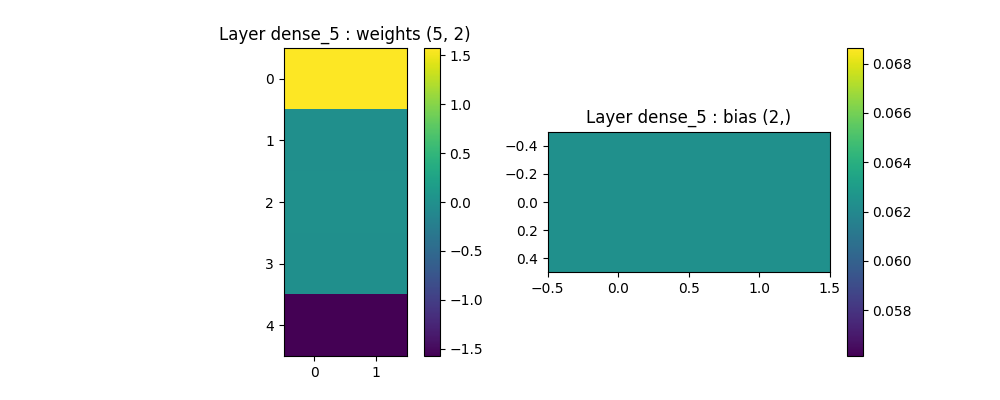

<IPython.core.display.Javascript object>


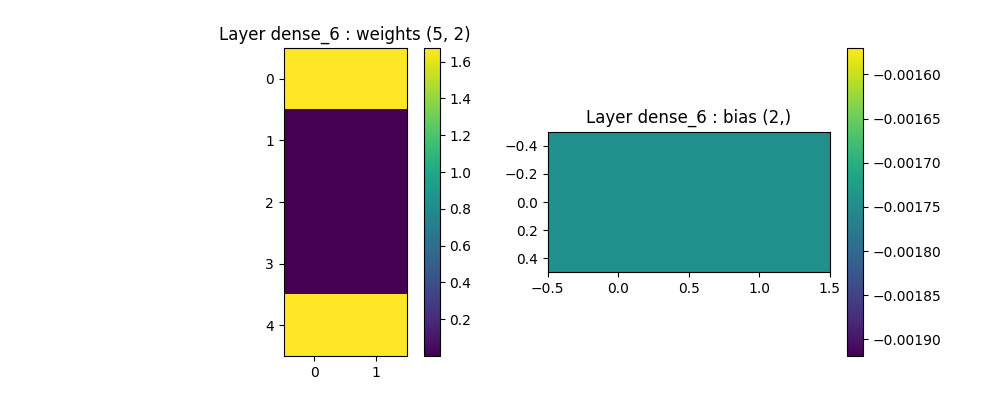

<IPython.core.display.Javascript object>


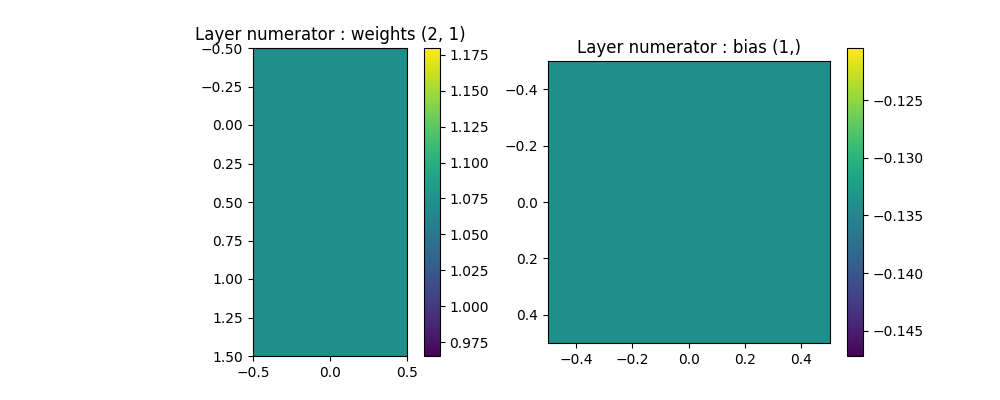

<IPython.core.display.Javascript object>


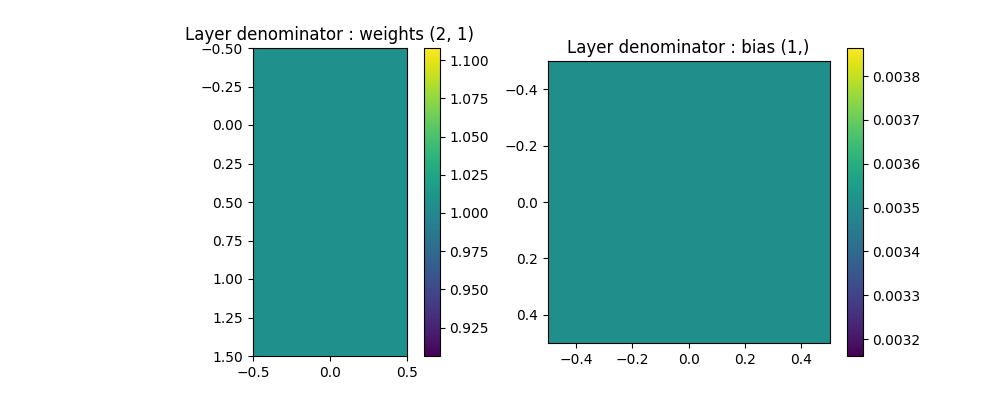

In [57]:
layers = list(model.layers)
layers.remove(model.input_layers[0])
for layer in layers:
    if not hasattr(layer, 'W'):
        continue
    weights = layer.W.eval()
    b = layer.b.eval()
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.title("Layer {} : weights {}".format(layer.name, weights.shape))
    plt.imshow(weights, interpolation='none')    
    plt.colorbar()
    plt.subplot(122)
    plt.title("Layer {} : bias {}".format(layer.name, b.shape))    
    b = np.expand_dims(b, axis=0)    
    plt.imshow(b, interpolation='none')    
    plt.colorbar()
    